# Covariance matrix change-point detection under graph stationarity assumption


## Problem formulation

Let $y = (y_1, \ldots, y_t, \ldots, y_T), y_t \in \mathbb{R}^{N}$ a graph signal lying on the nodes of the graph $G = (V, E, W)$, with $N =|V|$.

We aim at detecting changes of the (spatial) covariance matrix $\Sigma_t$ of the graph signals $y_t$. We assume that there exits an unknown set of change-points $\Tau = (t_1, \ldots, t_K) \subset [1, T]$ with unknown cardinality such that the covariance matrix of the graph signals is constant over any segment $[t_k, t_{k+1}]$. We do the following hypothesis:

1. the signals $y_t$ follow a multivariate Gaussian distribution with fixed covariance matrix over each segment, i.e:
$$\forall k \in [1, K] ~ \forall t \in [t_k, t_{k+1}] \quad y_t \sim \mathcal{N}(\mu, \Sigma_k)$$

2. over each segment, the signals $y_t$ verify the second order wide-sense graph stationarity:
$$\forall k \in [1, K] \quad \Sigma_k = U \text{diag}(\gamma_k)U^T $$

where the matrix $U$ contains the eigenvectors of the graph combinatorial Laplacian matrix $L = D - W$ in its columns. 

The Graph Fourier Transform $\tilde{y}$ of a signal $y$ is defined by $\tilde{y} = U^T y $.


Based on the above assumptions, the cost derived from the maximum log-likelihood over a segment $[a, b-1]$ writes:

\begin{align*}
    c(y_{a}, \ldots, y_{b-1}) = ~ & (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + ~ \sum_{t=a}^{b-1} \sum_{n=1}^N \frac{\left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2}{\hat{\gamma}_{a.b}^{(n)}} = ~ (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + N(b-a)
\end{align*}

where:

- $\hat{\mu}_{a..b}$ is the empirical mean of the process over $[a, b-1]$
- $\hat{\gamma}_{a..b}$ is the (empirical) biased correlogram/periodogram of the process over $[a, b-1]$: $\hat{\gamma}_{a..b} = \frac{1}{(b-a)} \sum_{t=a}^{b-1} \left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2$

##  Implementation


The evaluation of the above cost function requires the computation of: 

- the eigendecomposition of the graph Laplacian
- the empirical mean of the signal over all the available time steps
- the diagonal of the empirical covariance matrix of $\tilde{y_t}$

Possible methods for estimating the power spectral density:
- compute the $\tilde{y_t}$, then compute their variance (corresponds to correlogram and periodogram)
- use the graph Short Time Fourier Transform

### Computation of the cost

In [191]:
import numpy as np

from scipy.linalg import eigh
from ruptures.base import BaseCost

class CostGraphStatioNormal(BaseCost):

    """
    """

    model = "graph_sationary_normal_cost"

    def __init__(self, laplacian_mat) -> None:
        """
        Args:
            laplacian_mat (array): the discrete Laplacian matrix of the graph: D - W
            where D is the diagonal matrix diag(d_i) of the node degrees and W the adjacency matrix
        """
        self.graph_laplacian_mat = laplacian_mat
        self.signal = None
        self.gft_square_cumsum = None
        self.gft_mean = None
        self.min_size = laplacian_mat.shape[0]
        super().__init__()
    
    def fit(self, signal):
        """Performs pre-computations for per-segment approximation cost.

        NOTE: the number of dimensions of the signal and their ordering
        must match those of the nodes of the graph.
        The function eigh used below returns the eigenvector corresponding to 
        the ith eigenvalue in the ith column eigvect[:, i]

        Args:
            signal (array): of shape [n_samples, n_dim].
        """
        self.signal = signal
        # Computation of the GFSS
        _, eigvects = eigh(self.graph_laplacian_mat)
        gft =  signal @ eigvects # equals signal.dot(eigvects) = eigvects.T.dot(signal.T).T
        self.gft_mean = np.mean(gft, axis=0)
        # Computation of the per-segment cost utils
        self.gft_square_cumsum = np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum((gft - self.gft_mean[None, :])**2, axis=0)], axis=0)
        return self

    def error(self, start, end):
        """Return the L2 approximation cost on the segment [start:end] 
        where end is excluded, over the filtered signal.

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        if end - start < self.min_size:
            raise ValueError(f'end - start shoud be higher than {self.min_size}')
        sub_square_sum = self.gft_square_cumsum[end] - self.gft_square_cumsum[start]
        return (end  - start) * np.sum(np.log(sub_square_sum / (end - start)))


## Experiments

### Synthetic data

#### A. Data verifying the hypothesis of the model

In this experiment, we generate data according to the hypothesis presented in the [problem formulation](#problem-formulation) and we compare our method to the cost function for standard covariance change detection in Gaussian models (that is supposed to cover our hypothesis). More precisely, we randomly generate a graph and a corresponding multivariate Gaussian signal, undergoing a (known) random number of covariance change points. The comparison between the two methods relies on the precision, recall and F1 metrics.

#### Utils and visualization

In [192]:
import networkx as nx
import ruptures as rpt
import matplotlib.pyplot as plt

In [193]:
def generate_random_er_graphs(params_rng, nx_graph_seed, min_n_nodes=10, max_n_nodes=30, min_edge_p=0.15, max_edge_p=0.5):
    n_nodes = params_rng.integers(low=min_n_nodes, high=max_n_nodes+1)
    edge_p = min_edge_p + (max_edge_p-min_edge_p) * params_rng.random()
    G = nx.erdos_renyi_graph(n=n_nodes, p=edge_p, seed=nx_graph_seed)
    return G

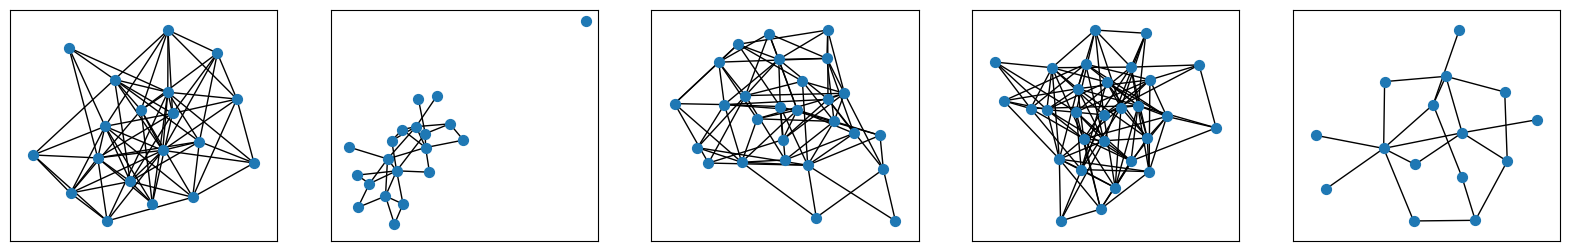

In [194]:
graph_seed = 0
params_seed = 1
fig, axes = plt.subplots(1, 5, figsize=(4*5, 3))
params_rng = np.random.default_rng(seed=params_seed)
for _ in range(5):
    G = generate_random_er_graphs(params_rng, graph_seed)
    coord = nx.spring_layout(G, seed=0)
    nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[_])

In [195]:
def draw_bkps_with_gap_constraint(n_samples, bkps_gap, bkps_rng, max_tries=10000):
    # randomly pick an admissible number of bkps
    n_bkps = bkps_rng.integers(low=1, high=n_samples//bkps_gap)
    bkps = []
    n_tries = 0
    # select admissible randomly drawn bkps
    while n_tries < max_tries and len(bkps) < n_bkps:
        new_bkp = bkps_rng.integers(low=bkps_gap, high=n_samples-bkps_gap)
        to_keep = True
        for bkp in bkps:
            if abs(new_bkp - bkp) < bkps_gap:
                to_keep = False
        if to_keep:
            bkps.append(new_bkp)
        n_tries+=1
    bkps.sort()
    return bkps + [n_samples]

In [183]:
def generate_gaus_signal_with_cov_diag_in_fourier(n_dims, n_samples, eigvects, signal_rng, diag_cov_max=1):
    # randomly draw diagonal coef (in the fourier space)
    diag_coefs = diag_cov_max * signal_rng.random(n_dims)
    diag_mat = np.diag(diag_coefs)
    # compute the corresponding covariance matrix and signal 
    cov_mat = eigvects @ diag_mat @ eigvects.T
    signal = signal_rng.multivariate_normal(np.zeros(n_dims), cov_mat, size=n_samples)
    return signal

In [184]:
def generate_rd_signal_in_hyp(G:nx.Graph, signal_rng:np.random.Generator, n_samples:int=500):
    # randomly draw a set of admissible change points
    n_dims = G.number_of_nodes()
    min_size = n_dims * (n_dims-1) / 2
    bkps = draw_bkps_with_gap_constraint(n_samples, min_size, signal_rng)
    # generate the signal
    _, eigvects = eigh(nx.laplacian_matrix(G).toarray())
    signal_gen_func = lambda size: generate_gaus_signal_with_cov_diag_in_fourier(n_dims, size, eigvects, signal_rng)
    signal = signal_gen_func(bkps[0])
    # add each sub-segment
    for i in range(1, len(bkps)):
        sub_signal = signal_gen_func(bkps[i] - bkps[i-1])
        signal = np.concatenate([signal, sub_signal], axis=0)
    return bkps, signal

In [189]:
def update_results(true_bkps, pred_bkps, results_dic, prec_rec_margin):
    preci, recall = rpt.metrics.precision_recall(true_bkps[:-1], pred_bkps[:-1], prec_rec_margin)
    hsdrf = rpt.metrics.hausdorff(true_bkps, pred_bkps)
    results_dic["precision"].append(preci)
    results_dic["recall"].append(recall)
    results_dic["hausdorff"].append(hsdrf)

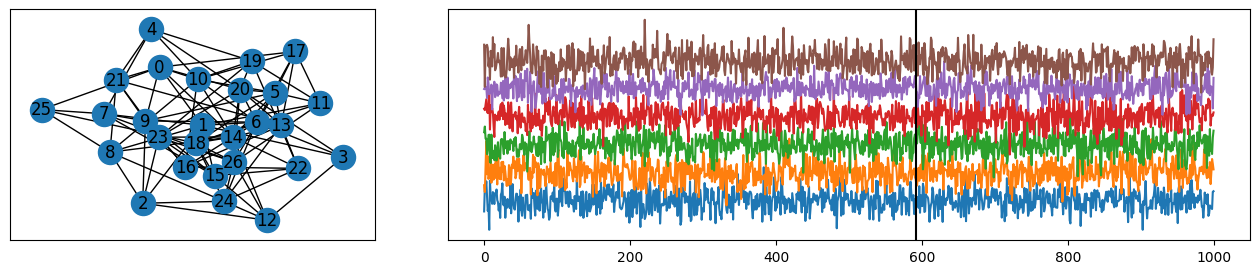

In [190]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 3

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

G = generate_random_er_graphs(graph_rng, nx_graph_seed)
bkps, s = generate_rd_signal_in_hyp(G, signal_rng, n_samples=1000)

fig, axes = plt.subplot_mosaic(mosaic='ABB', figsize=(16, 3))
nx.draw_networkx(G, ax=axes['A'])
for i in range(6):
    axes['B'].plot(2*i+s[:, i])
axes['B'].set_yticks([])
for bkp in bkps[:-1]:
    axes['B'].axvline(x=bkp, c='k')

In [81]:
N_EXP1 = 5
NX_GRAPH_SEED = 1
GRAPH_SEED = 2
SIGNAL_SEED = 3
PRECI_RECALL_MARGIN = 2

signal_rng = np.random.default_rng(seed=SIGNAL_SEED)
graph_rng = np.random.default_rng(seed=GRAPH_SEED)

statio_results = {"recall": [], "precision": [], "hausdorff": []}
normal_results = {"recall": [], "precision": [], "hausdorff": []}

for exp_id in range(N_EXP1):
    
    # data and ground truth generation
    G = generate_random_er_graphs(graph_rng, NX_GRAPH_SEED, max_n_nodes=25)
    gt_bkps, signal = generate_rd_signal_in_hyp(G, signal_rng, n_samples=1000)
    min_size = G.number_of_nodes()*(G.number_of_nodes()-1)/2

    # prediction with standard normal cost
    normal_cost = rpt.costs.CostNormal()
    algo1 = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
    normal_bkps = algo1.predict(n_bkps=len(bkps)-2)

    # prediction with stationary normal cost
    statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
    algo = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
    statio_bkps = algo.predict(n_bkps=len(bkps)-2)

    # performances evaluation
    update_results(gt_bkps, normal_bkps, normal_results, PRECI_RECALL_MARGIN)
    update_results(gt_bkps, statio_bkps, statio_results, PRECI_RECALL_MARGIN)


In [82]:
# No graph statio
normal_cost = rpt.costs.CostNormal()
algo = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
normal_bkps = algo.predict(n_bkps=len(bkps)-2)
print("WITHOUT GRAPH STATIO: ", bkps, normal_bkps)

# With graph statio
statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
algo = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
statio_bkps = algo.predict(n_bkps=len(bkps)-2)
print("WITH GRAPH STATIO: ", bkps, statio_bkps)

/home/matencioeve/dev/Borelli_X_RTE/graph-signals-change-point-detection/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


WITHOUT GRAPH STATIO:  [0, 250, 450, 790, 1020, 1300, 1800, 2000] [251, 450, 790, 1020, 1300, 1800, 2000]
WITH GRAPH STATIO:  [0, 250, 450, 790, 1020, 1300, 1800, 2000] [251, 450, 790, 1020, 1300, 1800, 2000]
